### <font color='darkblue'>Week 8 Computing Lab</font>

#### Working with Onotlogies and Functional Enrichment Analysis

##### (and a little bit of network analysis..)

##### <font color='darkblue'>Introduction</font>
In this computing lab we’re going to be putting together what we've learned about biological databases and ontologies to do some summary analysis of genes invovled in the "Dopaminergnic Synapse" pathway. These can all be done using the KEGG and String-DB websites directly but we will show here that there is much greater power and flexibility available when you start using programmatic methods to carefully control your analyses.

##### <font color='darkblue'>Learning Outcomes</font>
After this tutorial you should be comfortable with:
- Retrieving pathway information from KEGG
- converting between accession IDs of different databases
- Retrieving protein-protein interaction and network data from String-DB
- Automating these processes using APIs and the NetworkX, and GSEAPy python packages

## Step 1 - Setting up the Environment & Retrieving Data 

In [3]:
# Setting Up the Programming Environment
# %pip install networkx
# %pip install gseapy

# import modules for use in the notebook

# handling www based requests (like APIs)
import urllib as ul

# standard Python data handling modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# working with networks
import networkx as nx

# working with geen set enrichment analysis (GSEA)
import gseapy

For Step1 you can either use the fully automated approcah using Steps 1a, and 1b, or working from files you generate from the KEGG and String-DB websites as described in Step 1c.

### Step 1a - Automating Download of KEGG Pathway Information

In [4]:
# First we fetch the list of human pathways available at KEGG.

human_pathways = pd.read_csv(ul.request.urlopen('http://rest.kegg.jp/list/pathway/hsa'),sep='\t',header=0,names=['kegg_id','pathway_name'])
human_pathways.head()

# We specifically want the pathway data for the "Dopaminergic Synapse" pathway.
pathway_info = human_pathways[human_pathways['pathway_name'].str.match('Dopaminergic synapse')]['kegg_id']

# extract the exact pathway accession
pathway_id = pathway_info.values[0].split(':')[1]

print(pathway_id)

# pull the pathway directly from KEGG, note we are saving this to a file 'dop_synapse.txt' that we will use later
ul.request.urlretrieve('http://rest.kegg.jp/get/'+pathway_id,'dop_synapse.txt');

hsa04728


In [5]:
# Now we will use this file which contains the full pathway details including the gene names.

# open the file
dop_file = open('dop_synapse.txt','r')

# I wanted to show you some basic python parsing and a simple for loop with a conditional in to demonstrate how you can quickly build simple parsers.
# There are quicker ways to do this, but this is a good learning example.

# create an empty dataframe
dop_df = pd.DataFrame()

# set a flag for our parser
flag=0

# work through the text file one line at a time
for line in dop_file:
    # find the start of the gene entries
    if 'GENE' in line:
        # add the first gene tp the dataframe
        dop_df = dop_df.append(pd.Series(line.strip('GENE').strip().split('  ')),ignore_index=True)
        # set the flag to 1, we are in the gene section of the file
        flag = 1
    # stop when we reach the end of the section and escape the file
    elif 'COMPOUND' in line:
        break
    # continue adding the genes to the dataframe
    elif flag == 1:
        dop_df = dop_df.append(pd.Series(line.strip().split('  ',2)),ignore_index=True)

# close the file
dop_file.close()

# name the columns
dop_df.columns = ['gene_id','description']

# view the file
dop_df.head()

# you now have the gene_ids (NCBI EntrezIDs for the genes in the pathway)
print('The Dopaminergic Synapse pathway has '+str(dop_df.shape[0])+' genes in it.\n')

# show the gene_ids
print(dop_df['gene_id'].to_numpy())

The Dopaminergic Synapse pathway has 132 genes in it.

['7054' '1644' '6570' '6571' '1812' '1816' '50632' '2776' '23236' '5330'
 '5331' '5332' '3708' '3709' '3710' '810' '805' '808' '801' '163688'
 '51806' '91860' '815' '817' '816' '818' '5530' '5532' '5533' '5578'
 '5579' '5582' '2353' '2778' '2774' '111' '5566' '5567' '5568' '1385'
 '1386' '468' '10488' '90993' '64764' '84699' '148327' '9586' '1388'
 '5600' '6300' '5603' '1432' '5599' '5602' '5601' '84152' '5499' '5500'
 '5501' '6323' '775' '776' '773' '774' '3760' '3763' '3765' '3762' '1814'
 '1815' '2770' '2773' '2771' '2775' '2782' '2783' '2784' '59345' '10681'
 '54331' '2785' '2786' '2787' '2788' '94235' '2790' '2791' '55970' '51764'
 '2792' '2793' '1813' '408' '409' '5515' '5516' '5519' '5518' '5520'
 '5521' '5522' '55844' '28227' '55012' '5523' '5526' '5527' '5528' '5529'
 '5525' '207' '208' '10000' '2931' '2932' '2903' '2904' '2890' '2891'
 '2892' '2893' '3798' '3799' '3800' '9575' '406' '6531' '4129' '4128'
 '1312' '220074']


/var/folders/lp/s1cb0cqj2lsdwm5yp02dtvvc0000gn/T/ipykernel_73746/3845425260.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dop_df = dop_df.append(pd.Series(line.strip('GENE').strip().split('  ')),ignore_index=True)
/var/folders/lp/s1cb0cqj2lsdwm5yp02dtvvc0000gn/T/ipykernel_73746/3845425260.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dop_df = dop_df.append(pd.Series(line.strip().split('  ',2)),ignore_index=True)


### Step 1b - Automating Retrieval of Protein-Protein Interactions from STRING

The details of the String-DB API can be found here - [https://string-db.org/help/api/](https://string-db.org/help/api/)

APIs have specific formats required for their query URLs and it getting these correct in your code can take a little time until you get used to them. In this case we need to concatenate (stitch together) our gene IDs using a '%0D' string. This is actually the encoding for a line-return which is in effect mimicking the one gene per line entry that you would paste into the web page.

In [6]:
# create a concatenated list of entrezIDs as strings
# note we are taking integer gene_ids from the 'gene_id' column of the dataframe we generated above then using
# the map function to convert each one into a string. The join function then concatenates them using the '%0D' string
# to stitch them all together. This string will be used to help us build the API query URL.
entrezIDs = '%0D'.join(map(str,dop_df['gene_id']))

# pass the list of EntrezIDs to the String-DB API return the String-IDs
# we first form the query url using the 'get_string_ids' API function which takes a list of identifiers and
# converts them into the internal String-DB accession IDs. This massively speeds up the search and allows us to
# search for more than 10 at once which is an API restriction for other API functions if String-DB internal accessions 
# aren't used.
query_url = 'https://string-db.org/api/tsv-no-header/get_string_ids?identifiers='+entrezIDs+'&format=only-ids'

# use the urllib library to retrieve the String-DB internal IDs
result = ul.request.urlopen(query_url).read().decode('utf-8')

# now we want to query String-DB to retrieve interactions from this list of String-DB IDs
# we create a concatenated list of stringdbIDs in much the same way as above for the Entrez Gene IDs
stringdbIDs = '%0D'.join(result.splitlines())

# again we build the query for interactions using the String-DB IDs
query_url = 'https://string-db.org/api/tsv/network?identifiers='+stringdbIDs+'&species=9606'

# again using urllib to retrieve the interactions these are returned in a standard tab delimied text format
interactions = ul.request.urlopen(query_url).read().decode('utf-8').splitlines()

# we need to split the result by these 'tabs' (\t - is used to identfy them)
int_test = [interaction.split('\t') for interaction in interactions]

# we extract the field names from the first row
column_names = int_test[:1][0]

# create a Pandas dataframe of the interaction data we have just retrieved from String-DB
interactions_df = pd.DataFrame(int_test,columns=column_names)

# delete the first row that held the fieldnames but we no longer need
interactions_df = interactions_df.drop(labels=0,axis=0)

# remove any duplicate rows
final_interactions = interactions_df.drop_duplicates()

# show the top of the protein-protein interaction table
final_interactions.head()

stringId_A            stringId_B preferredName_A preferredName_B  \
1  9606.ENSP00000078445  9606.ENSP00000384517         CREB3L3           ARNTL   
3  9606.ENSP00000078445  9606.ENSP00000326031         CREB3L3          PPP1CA   
5  9606.ENSP00000078445  9606.ENSP00000263826         CREB3L3            AKT3   
7  9606.ENSP00000078445  9606.ENSP00000378769         CREB3L3          PPP1CB   
9  9606.ENSP00000078445  9606.ENSP00000339740         CREB3L3          CAMK2D   

  ncbiTaxonId  score nscore fscore pscore ascore escore dscore tscore  
1        9606   0.43      0      0      0      0      0      0   0.43  
3        9606    0.6      0      0      0      0      0    0.6      0  
5        9606    0.6      0      0      0      0      0    0.6      0  
7        9606    0.6      0      0      0      0      0    0.6      0  
9        9606  0.603      0      0      0      0      0    0.6  0.049

### Step 1c - Download Network from [STRING](https://string-db.org/cgi/input?sessionId=bIvRxxC0rWvS&input_page_show_search=on)

In string upload dop_geneids.txt to string (make sure to click on multiple proteins)

Select Homo Sapiens in Organism and click Search

Quickly double check the mapping is correct before clicking continue

You should now see your full protein-protein interaction network

What we would like to do is to identify clusters of enriched terms in this network

First step is to cluster the network. This can be achieved in STRING by selecting Clusters -> MCL Clustering

Change edge between clsuters to solid line

The next step is to download our clustered network. 

This is achieved by selceting Exports -> '... as tabular text output' 

This file is the full network with edges between every node. It is a '.tsv' format which can work with in Python

## Step 2 - Generating the Protein-Protein Interaction Network

Next we are going to use the NetworkX Python library to create the protein-protein interaction network.

NetworkX - Network Analysis in Python - [https://networkx.org/documentation/stable/index.html](https://networkx.org/documentation/stable/index.html)

### Step 2a - Working with the PPI dataframe created in Step 1b

Index(['stringId_A', 'stringId_B', 'preferredName_A', 'preferredName_B',
       'ncbiTaxonId', 'score', 'nscore', 'fscore', 'pscore', 'ascore',
       'escore', 'dscore', 'tscore'],
      dtype='object')


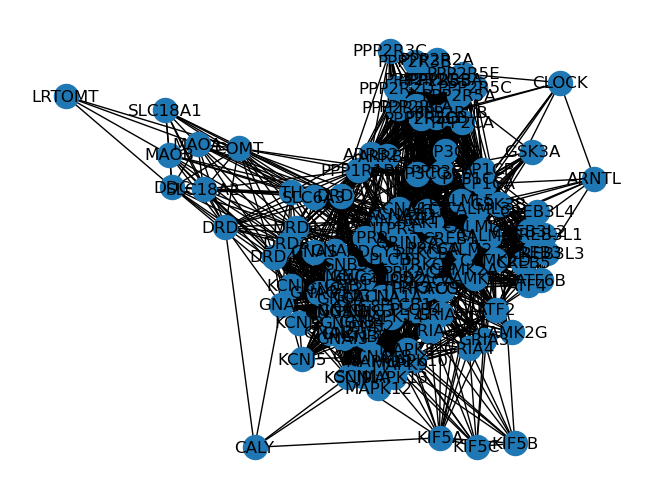

In [7]:
# check the column names of the dataframe
print(final_interactions.columns)

 #Create an empty graph
G = nx.Graph()

# add all nodes
G.add_nodes_from(set(final_interactions['preferredName_A']) | set(final_interactions['preferredName_B'])) 

# add the edges (connections) to the network
edges = []
for edge1 , edge2  in zip(final_interactions['preferredName_A'] , final_interactions['preferredName_B']) : #add all edge to the network
    edges.append((edge1 , edge2 ))
G.add_edges_from(edges)

# draw the network
nx.draw(G , with_labels = True)

### Step 2b - Working from the PPI file downloaded from the StringDB website in Step 1c

In [8]:
# read in the protein-protein interaction data from the downloaded String-DB tab separated file
df = pd.read_csv('string_interactions.tsv' , delimiter='\t')

# show the top of the table
df.head()

#node1  node2       node1_string_id       node2_string_id  \
0  ADCY5   GNB3  9606.ENSP00000419361  9606.ENSP00000229264   
1  ADCY5   GNB4  9606.ENSP00000419361  9606.ENSP00000232564   
2  ADCY5  GNG13  9606.ENSP00000419361  9606.ENSP00000248150   
3  ADCY5  GNG11  9606.ENSP00000419361  9606.ENSP00000248564   
4  ADCY5  GNGT1  9606.ENSP00000419361  9606.ENSP00000248572   

   neighborhood_on_chromosome  gene_fusion  phylogenetic_cooccurrence  \
0                           0          0.0                        0.0   
1                           0          0.0                        0.0   
2                           0          0.0                        0.0   
3                           0          0.0                        0.0   
4                           0          0.0                        0.0   

   homology  coexpression  experimentally_determined_interaction  \
0       0.0         0.085                                   0.07   
1       0.0         0.062                                   0.07   
2       0.0         0.103                                   0.00   
3       0.0         0.000                                   0.00   
4       0.0         0.000                                   0.00   

   database_annotated  automated_textmining  combined_score  
0                 0.6                 0.087           0.647  
1                 0.6                 0.164           0.669  
2                 0.6                 0.266           0.713  
3                 0.6                 0.077           0.615  
4                 0.6                 0.049           0.603

['GNG10', 'GSK3B', 'PPP2R3A', 'COMT', 'CREB3', 'DDC', 'GSK3A', 'PPP2CB', 'ATF2', 'MAPK14', 'CREB3L1', 'DRD4', 'PPP2R5D', 'CAMK2B', 'PPP2R5A', 'PLCB3', 'CALM2', 'CAMK2A', 'PPP2CA', 'PRKCB', 'MAPK13', 'PPP2R5B', 'CLOCK', 'CALML3', 'CACNA1C', 'PRKACG', 'GNG12', 'ATF4', 'ARRB2', 'CACNA1B', 'GNG11', 'CACNA1D', 'GNAL', 'PRKACA', 'PPP2R2D', 'MAPK10', 'LRTOMT', 'PPP2R2B', 'PPP2R3B', 'GRIN2B', 'PPP1R1B', 'GNB2', 'MAPK11', 'PLCB1', 'ITPR1', 'CACNA1A', 'DRD1', 'GRIA2', 'GNAS', 'CALML5', 'KCNJ5', 'SLC18A1', 'PPP3CB', 'CAMK2G', 'PRKCG', 'GNAI3', 'AKT3', 'KIF5B', 'PRKACB', 'KIF5C', 'SCN1A', 'MAPK9', 'AKT1', 'ARNTL', 'GNAO1', 'CALML6', 'GNB3', 'SLC6A3', 'CREB5', 'DRD2', 'PLCB4', 'GRIA1', 'CREB3L3', 'GRIA3', 'PPP3CA', 'GRIA4', 'GNG13', 'KCNJ6', 'CALML4', 'ITPR2', 'GNGT2', 'AKT2', 'PPP2R1B', 'ADCY5', 'PLCB2', 'GNGT1', 'KCNJ9', 'FOS', 'CREB3L4', 'GNB4', 'DRD5', 'GRIN2A', 'PPP2R5E', 'MAOA', 'GNAQ', 'GNG3', 'CREB3L2', 'GNB5', 'PPP1CB', 'GNB1', 'TH', 'PRKCA', 'GNG7', 'MAOB', 'PPP2R2A', 'GNG2', 'ATF6B', 'GN

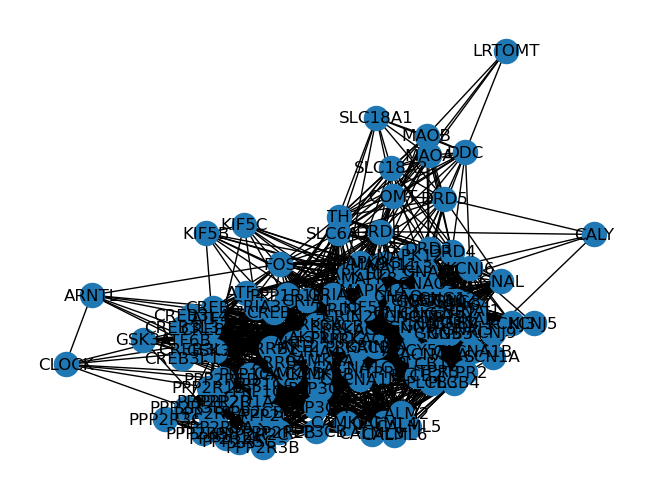

In [9]:
# check the column names of the dataframe
# print(df.columns)

 #Create an empty graph
G = nx.Graph()

# add all nodes. Note we need to cover the scenario where node2 is connected to node1 only
G.add_nodes_from(set(df['#node1']) |  set(df['node2']))

# add the edges (connections) to the network
edges = []
for edge1 , edge2  in zip(df['#node1'] , df['node2']) :
    edges.append((edge1 , edge2 ))

G.add_edges_from(edges)

# draw the network
nx.draw(G , with_labels = True)

#note how we keep our gene ids in the node names
print(G.nodes)

## Step 3 - Gene Set Enrichement Analysis for our Network

### [GSEApy](https://gseapy.readthedocs.io/en/latest/index.html)

[GSEApy](https://gseapy.readthedocs.io/en/latest/index.html) is a library to perform gene set enrichment analysis (GSEA) in python. There are two methods to perform enrichment analysis - over representation analysis and GSEA. The main difference between the two is that GSEA assumes your input list of genes is ordered by the most representative genes in that list. 

### Enrichment Analysis Measures

In order to perform GSEA we need to impose an ordering on the list of gene ids. We want to order genes such that the genes which are most important to the above network are listed highest. 

Important genes to the network are ones that are central to the network structural i.e. removing these nodes will split the network or cause it to lose its structure. This means they tend to have highest number of connections and located in the centres of clusters.

You can browse the available gene sets to perform enrichment analysis against using the GSEAPy package at the [Enrichr website](https://maayanlab.cloud/Enrichr/#libraries).

### Step 3a - Node Degree

Node degree is simply the number of connections a node has. The higher the number of connections, the more important the node

In [10]:
#sort the genes (node names) by degree
sorted_list = sorted(G.degree(), key=lambda item: item[1] , reverse=True)

#extract just the node names from the sorted list
sorted_genes = []
for item in sorted_list :
    sorted_genes.append(item[0])
    
# perform enrichment analysis using gsea
enr = gseapy.enrichr(gene_list=sorted_genes,
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

enr.results.head(10) #return the top 10 hits

Gene_set                                    Term  Overlap  \
0  KEGG_2021_Human                    Dopaminergic synapse  130/132   
1  KEGG_2021_Human                   Circadian entrainment    59/97   
2  KEGG_2021_Human                     Cholinergic synapse   58/113   
3  KEGG_2021_Human                   Amphetamine addiction    51/69   
4  KEGG_2021_Human  Adrenergic signaling in cardiomyocytes   61/150   
5  KEGG_2021_Human         Human cytomegalovirus infection   63/225   
6  KEGG_2021_Human               Relaxin signaling pathway   54/129   
7  KEGG_2021_Human    Retrograde endocannabinoid signaling   55/148   
8  KEGG_2021_Human                    Serotonergic synapse   50/113   
9  KEGG_2021_Human                   Glutamatergic synapse   50/114   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   0.000000e+00      0.000000e+00            0                     0   
1  1.618525e-109     1.569969e-107            0                     0   
2  2.384583e-101      1.542030e-99            0                     0   
3  5.358995e-101      2.599113e-99            0                     0   
4   8.817867e-99      3.421332e-97            0                     0   
5   6.260912e-90      2.024362e-88            0                     0   
6   1.315167e-87      3.644892e-86            0                     0   
7   9.433667e-86      2.287664e-84            0                     0   
8   2.421368e-82      5.219393e-81            0                     0   
9   4.296495e-82      8.335199e-81            0                     0   

     Odds Ratio  Combined Score  \
0  2.582840e+06             inf   
1  4.336872e+02    1.086388e+05   
2  2.902197e+02    6.724160e+04   
3  7.119916e+02    1.643863e+05   
4  1.964893e+02    4.436319e+04   
5  1.143914e+02    2.349580e+04   
6  1.875316e+02    3.751587e+04   
7  1.559477e+02    3.053113e+04   
8  1.964980e+02    3.692741e+04   
9  1.934180e+02    3.623766e+04   

                                               Genes  
0  ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;COMT;...  
1  CALML5;CALML6;CALML3;CALML4;GNGT1;GNGT2;PRKACG...  
2  GNGT1;GNGT2;CREB3L3;CREB3L4;CREB3L1;AKT2;PRKAC...  
3  ATF2;CALML5;CALML6;CALML3;CALML4;SLC6A3;PPP1CB...  
4  ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;PPP1C...  
5  ATF2;GSK3B;CALML5;CALML6;CALML3;CALML4;GNGT1;P...  
6  ATF2;ARRB1;ARRB2;GNGT1;GNGT2;CREB3L3;CREB3L4;C...  
7  GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;PRKCG;PRKCB;P...  
8  GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;SLC18A1;SLC18...  
9  GNGT1;PPP3CA;PPP3CB;GNGT2;PPP3CC;PRKACG;PRKACA...

### Step 3b - Closeness Centrality 
This is a measure of how close a node is to the center of the network. The closer a node is to the center the shorter its path to all other nodes and hence its more likely to be representative of the network

In [11]:
sorted_list = sorted(nx.closeness_centrality(G).items(), key=lambda item: item[1] , reverse=True) 
#sort the genes (node names) by proximity to center

sorted_genes = []
for item in sorted_list : #extract just the node names from the sorted list
    sorted_genes.append(item[0])
    
enr = gseapy.enrichr(gene_list=sorted_genes, # perform enrichment analysis using gsea
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

enr.results.head(10) #return the top 10 hits

Gene_set                                    Term  Overlap  \
0  KEGG_2021_Human                    Dopaminergic synapse  130/132   
1  KEGG_2021_Human                   Circadian entrainment    59/97   
2  KEGG_2021_Human                     Cholinergic synapse   58/113   
3  KEGG_2021_Human                   Amphetamine addiction    51/69   
4  KEGG_2021_Human  Adrenergic signaling in cardiomyocytes   61/150   
5  KEGG_2021_Human         Human cytomegalovirus infection   63/225   
6  KEGG_2021_Human               Relaxin signaling pathway   54/129   
7  KEGG_2021_Human    Retrograde endocannabinoid signaling   55/148   
8  KEGG_2021_Human                    Serotonergic synapse   50/113   
9  KEGG_2021_Human                   Glutamatergic synapse   50/114   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   0.000000e+00      0.000000e+00            0                     0   
1  1.618525e-109     1.569969e-107            0                     0   
2  2.384583e-101      1.542030e-99            0                     0   
3  5.358995e-101      2.599113e-99            0                     0   
4   8.817867e-99      3.421332e-97            0                     0   
5   6.260912e-90      2.024362e-88            0                     0   
6   1.315167e-87      3.644892e-86            0                     0   
7   9.433667e-86      2.287664e-84            0                     0   
8   2.421368e-82      5.219393e-81            0                     0   
9   4.296495e-82      8.335199e-81            0                     0   

     Odds Ratio  Combined Score  \
0  2.582840e+06             inf   
1  4.336872e+02    1.086388e+05   
2  2.902197e+02    6.724160e+04   
3  7.119916e+02    1.643863e+05   
4  1.964893e+02    4.436319e+04   
5  1.143914e+02    2.349580e+04   
6  1.875316e+02    3.751587e+04   
7  1.559477e+02    3.053113e+04   
8  1.964980e+02    3.692741e+04   
9  1.934180e+02    3.623766e+04   

                                               Genes  
0  ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;COMT;...  
1  CALML5;CALML6;CALML3;CALML4;GNGT1;GNGT2;PRKACG...  
2  GNGT1;GNGT2;CREB3L3;CREB3L4;CREB3L1;AKT2;PRKAC...  
3  ATF2;CALML5;CALML6;CALML3;CALML4;SLC6A3;PPP1CB...  
4  ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;PPP1C...  
5  ATF2;GSK3B;CALML5;CALML6;CALML3;CALML4;GNGT1;P...  
6  ATF2;ARRB1;ARRB2;GNGT1;GNGT2;CREB3L3;CREB3L4;C...  
7  GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;PRKCG;PRKCB;P...  
8  GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;SLC18A1;SLC18...  
9  GNGT1;PPP3CA;PPP3CB;GNGT2;PPP3CC;PRKACG;PRKACA...

### Step 3c - Clustering Coefficient
The clustering coefficient is a measure which combines centrality and degree. It measures the number of triangles a node can form ('the friend of my friend is my friend'). If a node has more common friends with other nodes it more likely to representative of the network

In [12]:
sorted_list = sorted(nx.clustering(G).items(), key=lambda item: item[1] , reverse=True)
#sort the genes (node names) by clustering coefficient

sorted_genes = []
for item in sorted_list : #extract just the node names from the sorted list
    sorted_genes.append(item[0])
    
enr = gseapy.enrichr(gene_list=sorted_genes, # perform enrichment analysis using gsea
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

enr.results.head(10) #return the top 10 hits

Gene_set                                    Term  Overlap  \
0  KEGG_2021_Human                    Dopaminergic synapse  130/132   
1  KEGG_2021_Human                   Circadian entrainment    59/97   
2  KEGG_2021_Human                     Cholinergic synapse   58/113   
3  KEGG_2021_Human                   Amphetamine addiction    51/69   
4  KEGG_2021_Human  Adrenergic signaling in cardiomyocytes   61/150   
5  KEGG_2021_Human         Human cytomegalovirus infection   63/225   
6  KEGG_2021_Human               Relaxin signaling pathway   54/129   
7  KEGG_2021_Human    Retrograde endocannabinoid signaling   55/148   
8  KEGG_2021_Human                    Serotonergic synapse   50/113   
9  KEGG_2021_Human                   Glutamatergic synapse   50/114   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   0.000000e+00      0.000000e+00            0                     0   
1  1.618525e-109     1.569969e-107            0                     0   
2  2.384583e-101      1.542030e-99            0                     0   
3  5.358995e-101      2.599113e-99            0                     0   
4   8.817867e-99      3.421332e-97            0                     0   
5   6.260912e-90      2.024362e-88            0                     0   
6   1.315167e-87      3.644892e-86            0                     0   
7   9.433667e-86      2.287664e-84            0                     0   
8   2.421368e-82      5.219393e-81            0                     0   
9   4.296495e-82      8.335199e-81            0                     0   

     Odds Ratio  Combined Score  \
0  2.582840e+06             inf   
1  4.336872e+02    1.086388e+05   
2  2.902197e+02    6.724160e+04   
3  7.119916e+02    1.643863e+05   
4  1.964893e+02    4.436319e+04   
5  1.143914e+02    2.349580e+04   
6  1.875316e+02    3.751587e+04   
7  1.559477e+02    3.053113e+04   
8  1.964980e+02    3.692741e+04   
9  1.934180e+02    3.623766e+04   

                                               Genes  
0  ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;COMT;...  
1  CALML5;CALML6;CALML3;CALML4;GNGT1;GNGT2;PRKACG...  
2  GNGT1;GNGT2;CREB3L3;CREB3L4;CREB3L1;AKT2;PRKAC...  
3  ATF2;CALML5;CALML6;CALML3;CALML4;SLC6A3;PPP1CB...  
4  ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;PPP1C...  
5  ATF2;GSK3B;CALML5;CALML6;CALML3;CALML4;GNGT1;P...  
6  ATF2;ARRB1;ARRB2;GNGT1;GNGT2;CREB3L3;CREB3L4;C...  
7  GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;PRKCG;PRKCB;P...  
8  GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;SLC18A1;SLC18...  
9  GNGT1;PPP3CA;PPP3CB;GNGT2;PPP3CC;PRKACG;PRKACA...

## Step 4 - Exploring Gene Ontology Annotations

In this step we use biomart which is an excellent service run at EBI-Ensembl that allows you to query and retrieve linked data for genomic data.

The help for Biomart can be found here - [https://www.ensembl.org/info/data/biomart/how_to_use_biomart.html](https://www.ensembl.org/info/data/biomart/how_to_use_biomart.html)

Biomart API functionality is nicely delivered through GSEApy and its use is described here - [https://gseapy.readthedocs.io/en/latest/gseapy_example.html#1.-Biomart-API](https://gseapy.readthedocs.io/en/latest/gseapy_example.html#1.-Biomart-API).

In [13]:
# read in the Entrez Gene IDs for the Dopaminergic Synapse pathway
# **you could pull the pathway details as in Step 1a above.
gene_ids = pd.read_table('dop_geneids.txt' , header=None , names=['gene_ids'])

gene_ids.head()

gene_ids
0      7054
1      1644
2      6570
3      6571
4      1812

In [14]:
# the GSEApy package also contains functions that allow you to use the EBI-Ensembl Biomart service
# you can use this to directly query linked data for the genes, including Gene Ontology (GO) annotation data.
from gseapy import Biomart

# initiate a biomart connection
bm = Biomart()

# form a query for biomart from the Entrez Gene IDs
queries = {'entrezgene_id' :list(gene_ids.values.reshape(1,-1)[0])}

# execute the biomart query
# NB that the oddly named 'name_1006' attribute is in fact the 'GO Term name' attribute
# NB a nice trick for finding the correct attribute names is to use the website to create the query and then
# NB click on the XML link at the top of the page, this will show you the 'Attribute name'.
results = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id','go_linkage_type','name_1006'],
                   filters=queries)

# change the name to something more useful
results.rename({'name_1006' : 'go_name'},axis=1,inplace=True)

results.head()

ensembl_gene_id external_gene_name  entrezgene_id       go_id  \
0  ENSG00000275199               AKT3          10000  GO:0005524   
1  ENSG00000275199               AKT3          10000  GO:0004672   
2  ENSG00000275199               AKT3          10000  GO:0006468   
3  ENSG00000275199               AKT3          10000  GO:0004674   
4  ENSG00000275199               AKT3          10000  GO:2000773   

  go_linkage_type                                     go_name  
0             IEA                                 ATP binding  
1             IEA                     protein kinase activity  
2             IEA                     protein phosphorylation  
3             IEA    protein serine/threonine kinase activity  
4             IMP  negative regulation of cellular senescence

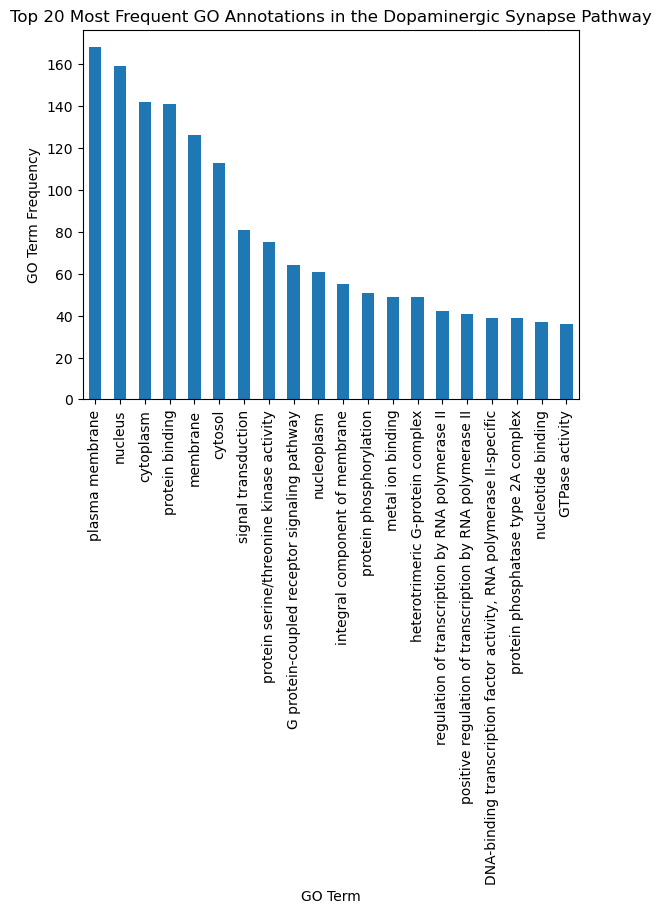

In [15]:
#Plot the top 20 most common GO terms
top_20_GO = results['go_name'].value_counts()[:20];

top_20_GO.plot.bar(xlabel='GO Term',ylabel='GO Term Frequency',title='Top 20 Most Frequent GO Annotations in the Dopaminergic Synapse Pathway');


go_linkage_type                                HDA   IBA   IDA   IEA  IPI  \
go_name                                                                     
ATP binding                                    0.0   0.0   0.0  30.0  0.0   
G protein-coupled receptor signaling pathway   0.0   0.0   0.0  29.0  0.0   
cytoplasm                                      0.0  32.0  27.0  66.0  0.0   
cytosol                                        0.0   0.0   0.0   0.0  0.0   
extracellular exosome                         31.0   0.0   0.0   0.0  0.0   

go_linkage_type                                TAS  
go_name                                             
ATP binding                                    0.0  
G protein-coupled receptor signaling pathway   0.0  
cytoplasm                                      0.0  
cytosol                                       54.0  
extracellular exosome                          0.0

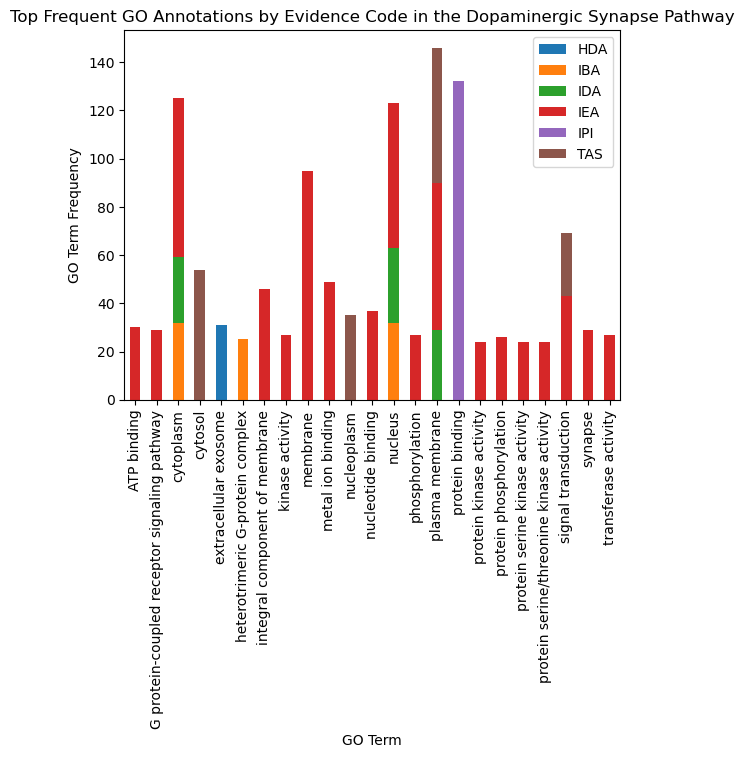

In [16]:
# just to take extra advantage of the data lets break down the above by evidence code type
annotations_by_evidence = pd.DataFrame(results[['go_name','go_linkage_type']].dropna())

# we use the Pandas pivot_table function to count and sort the pairs go_term & evidnce code
annotations_by_evidence = annotations_by_evidence.pivot_table(index=['go_name','go_linkage_type'],aggfunc='size').reset_index(name='frequency').sort_values(by='frequency',ascending=False)

# just take the top 30 rows
top_annotations = annotations_by_evidence[:30]

# pivot to create a nice matrix for a stacked plot
top_annotations = top_annotations.pivot(index='go_name',columns='go_linkage_type',values='frequency').fillna(0)

# create a stacked barchart of the results
top_annotations.plot.bar(xlabel='GO Term',
    ylabel='GO Term Frequency',
    title='Top Frequent GO Annotations by Evidence Code in the Dopaminergic Synapse Pathway',
    stacked=True).legend(loc='best');

# the nicely reshaped data frame used for the stacked plot
top_annotations.head()

Check the function of the most common GO terms [here](https://www.ebi.ac.uk/QuickGO/)

## Step5 - [PantherDB](http://www.pantherdb.org/)

[PantherDB](http://www.pantherdb.org/) is another online tool which can be used to perform an enrichment analysis.

### Step 5a - Using the PantherDB Website for Enrichment Analysis

In [17]:
# generate a unique list of Dopaminergic Synapse genes from our earlier dataframe
dop_genes = list(dop_df['gene_id'].dropna().drop_duplicates())

# write them to a file to upload to the PantherDB website
with open('entrezgene_id.txt', 'w') as f:
    f.write('\n'.join(str(gene) for gene in dop_genes))

Upload this file on the [PantherDB](http://www.pantherdb.org/) website

Select Functional classification viewed in graphic charts bar chart and be sure to select "Homo sapiens" as species

Do the GO terms match up to that found in PantherDB, why or why not? 

### Step 5b - Using the PantherDB API for Enrichment Analysis

PantherDB API details - [http://pantherdb.org/services/details.jsp](http://pantherdb.org/services/details.jsp)

Functionality and Parameter testing - [http://pantherdb.org/services/openAPISpec.jsp](http://pantherdb.org/services/openAPISpec.jsp)

This is quite hard work so you might decide it's simplest (and quicker) at this stage to use the website functionality above).

In [18]:
# results are returned in JSON format so we need to load a Python module to handle this
import json

# the PantherDB API offers this function to find out what annotated resources it has available
query_url = 'http://pantherdb.org/services/oai/pantherdb/supportedannotdatasets'

# execute the query
result = ul.request.urlopen(query_url)

# load the results returning a Python dictionary
annotationSets = json.load(result)

annotations = annotationSets['search']['annotation_data_sets']['annotation_data_type']

# we can just iterate through these to see the annotation sources available
for i in annotations:
    print('Annotation Set Label = '+i['label']+', annotDataSet string to use below = '+i['id'])

Annotation Set Label = molecular_function, annotDataSet string to use below = GO:0003674
Annotation Set Label = biological_process, annotDataSet string to use below = GO:0008150
Annotation Set Label = cellular_component, annotDataSet string to use below = GO:0005575
Annotation Set Label = PANTHER GO Slim Molecular Function, annotDataSet string to use below = ANNOT_TYPE_ID_PANTHER_GO_SLIM_MF
Annotation Set Label = PANTHER GO Slim Biological Process, annotDataSet string to use below = ANNOT_TYPE_ID_PANTHER_GO_SLIM_BP
Annotation Set Label = PANTHER GO Slim Cellular Location, annotDataSet string to use below = ANNOT_TYPE_ID_PANTHER_GO_SLIM_CC
Annotation Set Label = protein class, annotDataSet string to use below = ANNOT_TYPE_ID_PANTHER_PC
Annotation Set Label = ANNOT_TYPE_PANTHER_PATHWAY, annotDataSet string to use below = ANNOT_TYPE_ID_PANTHER_PATHWAY
Annotation Set Label = ANNOT_TYPE_REACTOME_PATHWAY, annotDataSet string to use below = ANNOT_TYPE_ID_REACTOME_PATHWAY


In [19]:
# using the list of Entrez Gene IDs generated above (entrezgene_id) create a query string for the API
# these need to be comma separated
genes = ','.join(map(str,dop_genes))

# use the PantherDB API - NB that GO:0008150 is the accession for the "Biological Process" clade of the Gene Ontology from above
query_url = "http://pantherdb.org/services/oai/pantherdb/enrich/overrep?&geneInputList="+genes+"&organism=9606&annotDataSet=GO:0008150&enrichmentTestType=FISHER&correction=FDR"

# capture the results (NB this returns in JSON format)
result = ul.request.urlopen(query_url)

# load the results from JSON to Python dictionary
enrichment_result = json.load(result)

# view the raw results
print(enrichment_result)

{'results': {'reference': {'organism': 'Homo sapiens', 'mapped_count': 20589, 'unmapped_count': 0}, 'input_list': {'organism': 'Homo sapiens', 'mapped_count': 83, 'mapped_id': [9586, 5582, 3760, 2793, 1385, 2353, 2792, 2790, 2788, 2787, 2786, 2785, 2783, 5578, 5579, 4128, 3798, 1816, 3710, 4129, 1815, 2904, 3799, 2903, 1814, 6323, 28227, 220074, 1388, 1386, 5500, 3762, 801, 3763, 207, 208, 406, 3765, 408, 805, 409, 3800, 808, 6570, 5520, 2771, 2892, 2891, 2770, 2890, 773, 1312, 775, 776, 815, 5515, 816, 817, 818, 5330, 6300, 5331, 5532, 5499, 2782, 23236, 2778, 2932, 2776, 3708, 3709, 2773, 468, 2893, 5522, 10000, 10681, 5601, 5525, 5526, 10488, 5527, 5528], 'unmapped_count': 49, 'unmapped_id': [7054, 1644, 6571, 1812, 50632, 5332, 810, 163688, 51806, 91860, 5530, 5533, 2774, 111, 5566, 5567, 5568, 90993, 64764, 84699, 148327, 5600, 5603, 1432, 5599, 5602, 84152, 5501, 774, 2775, 2784, 59345, 54331, 94235, 2791, 55970, 51764, 1813, 5516, 5519, 5518, 5521, 55844, 55012, 5523, 5529, 2931

We're now going to format that into something human readable. There are many ways to do this, but this is a quick and (fairly) simple solution. Please do feel free to try your own.

In [20]:
# extract the actual result component
results = enrichment_result['results']['result']

# how long is the background list (in this case it is the default, the whole genome)
print(len(results), "terms in reference list")

# print some headers
display_headers = ["GO Term", "Expected", "Fold enrichment", "raw P value", "FDR", "Term label"]
print("\t".join(display_headers))

# Sort in order of false discovery rate i.e. multiple testing correction
results.sort(key=lambda x: x['fdr'], reverse=False)

# iterate through all of the results and print out the biots we're interested in
for r in results:
    fdr = r['fdr']
    if fdr < 0.05:
        # Print result line
        term_id = r['term'].get("id")
        if term_id is None:
            term_id = ""
        else:
            print("\t".join([
                term_id,
                str(r['expected']),  # Convert float to string for printing
                str(r['fold_enrichment']),
                str(r['pValue']),
                str(r['fdr']),
                r['term']["label"]
            ])
            )

# that was quite painful

15681 terms in reference list
GO Term	Expected	Fold enrichment	raw P value	FDR	Term label
GO:0007154	37.621545485453396	2.7643734104493993	2.4513748047560964e-30	3.844000831338035e-26	cell communication
GO:0023052	36.83981737821167	2.7687433667987262	1.8881099586278582e-29	1.4803726130621722e-25	signaling
GO:0007165	34.417164505318375	2.7021400901759063	1.0282111992805284e-24	5.374459938639322e-21	signal transduction
GO:0043269	4.986157657001311	7.219988310929282	1.538318988228146e-20	6.03059501360139e-17	regulation of ion transport
GO:0051716	46.26281023847685	2.1399478217962113	7.232457621937186e-19	2.2682433593919402e-15	cellular response to stimulus
GO:0050896	57.812666958084414	1.90269720785849	2.354935314679179e-18	6.154623444914034e-15	response to stimulus
GO:0032879	14.817621059789209	3.5768224727940208	4.3160868413845105e-17	8.460069719968814e-14	regulation of localization
GO:0010959	2.8874641799018894	9.00444070647603	4.240147440280563e-17	9.498536001577073e-14	regulation of 

In [21]:
# %pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [45]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["GO Term", "Expected", "Fold enrichment", "raw P value", "FDR", "Term label"]

# Sort in order of false discovery rate i.e. multiple testing correction
results.sort(key=lambda x: x['fdr'], reverse=False)

# show the top10 results
for r in results[:10]:
    fdr = r['fdr']
    if fdr < 0.05:
        # Print result line
        term_id = r['term'].get("id")
        if term_id is None:
            term_id = ""
        else:
            current_row = [
                term_id,
                str('{0:.3f}'.format(r['expected'])),  # Convert float to string for printing
                str('{0:.3f}'.format(r['fold_enrichment'])),
                str('{0:.3g}'.format(r['pValue'])),
                str('{0:.3g}'.format(r['fdr'])),
                r['term']["label"]
            ]
    x.add_row(current_row)

print(x)

# that was quite painful

+------------+----------+-----------------+-------------+----------+---------------------------------------+
|  GO Term   | Expected | Fold enrichment | raw P value |   FDR    |               Term label              |
+------------+----------+-----------------+-------------+----------+---------------------------------------+
| GO:0007154 |  37.622  |      2.764      |   2.45e-30  | 3.84e-26 |           cell communication          |
| GO:0023052 |  36.840  |      2.769      |   1.89e-29  | 1.48e-25 |               signaling               |
| GO:0007165 |  34.417  |      2.702      |   1.03e-24  | 5.37e-21 |          signal transduction          |
| GO:0043269 |  4.986   |      7.220      |   1.54e-20  | 6.03e-17 |      regulation of ion transport      |
| GO:0051716 |  46.263  |      2.140      |   7.23e-19  | 2.27e-15 |     cellular response to stimulus     |
| GO:0050896 |  57.813  |      1.903      |   2.35e-18  | 6.15e-15 |          response to stimulus         |
| GO:0032879 |  14.